In [34]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import matplotlib.pyplot as plt

In [35]:
#==================
# Reproducibility
#==================
seed = 42
rng = np.random.default_rng(seed)

#=================================
# Data: sparse linear regression
#=================================
def make_sparse_regression(n = 450 , p = 200 , k = 8 , noise = 1.2 , seed = 42):
    rng = np.random.default_rng(seed)
    X = rng.normal(0 , 1 , size = (n , p))
    w_true = np.zeros(p)
    support = rng.choice(p , size = k , replace = False)
    w_true[support] = rng.normal(0 , 2.0 , size = k)
    y = X @ w_true + rng.normal(0 , noise , size = n)
    return X , y , w_true , support

X , y , w_true , support = make_sparse_regression(n = 450 , p = 200 , k = 8 , noise = 1.2 , seed = seed)

In [36]:
#================
# 60/20/20 split
#================
idx = rng.permutation(X.shape[0])
n_tr = int(0.6 * len(idx))
n_va = int(0.2 * len(idx))
tr , va , te = idx[ : n_tr] , idx[n_tr : n_tr + n_va] , idx[n_tr + n_va :]

Xtr , Xva , Xte = X[tr] , X[va] , X[te]
ytr , yva , yte = y[tr] , y[va] , y[te]

In [37]:
#==============
# Standardize
#==============
X_mean = Xtr.mean(axis = 0)
X_std = Xtr.std(axis = 0) + 1e-12
y_mean = ytr.mean()

Xtr_s = (Xtr - X_mean) / X_std
Xva_s = (Xva - X_mean) / X_std
Xte_s = (Xte - X_mean) / X_std
ytr_c = ytr - y_mean
yva_c = yva - y_mean
yte_c = yte - y_mean

In [38]:
def mse(X , y , w):
    r = X @ w - y
    return np.mean(r ** 2)

In [39]:
#==================================================
# Coordinate Descent for Lasso
# Objective: (1/2n)||y - Xw||^2 + alpha * ||w||_1
#==================================================
def soft_threshold(z , gamma):
    if z > gamma:
        return z - gamma
    if z < -gamma:
        return z + gamma
    return 0.0

In [40]:
def lasso_cd(X , y , alpha , iters = 80 , w0 = None):
    n , p = X.shape
    w = np.zeros(p) if w0 is None else w0.copy()
    col_norm = (X ** 2).mean(axis = 0) + 1e-12

    obj = []
    nnz = []

    for _ in range(iters):
        for j in range(p):
            # partial residual excluding j
            r = y - (X @ w) + X[ : , j] * w[j]
            rho = (X[ : , j] @ r) / n
            w[j] = soft_threshold(rho , alpha) / col_norm[j]

        obj.append(0.5 * mse(X , y , w) + alpha * np.sum(np.abs(w)))
        nnz.append(int(np.sum(np.abs(w) > 1e-8)))

    return w , np.array(obj) , np.array(nnz)

In [41]:

# -----------------------------
# Baseline: Least Squares (dense)
# -----------------------------
w_ls, *_ = np.linalg.lstsq(Xtr_s, ytr_c, rcond=None)
ls_val = mse(Xva_s, yva_c, w_ls)
ls_test = mse(Xte_s, yte_c, w_ls)

In [42]:
#===============================
# Alpha sweep with warm starts
#===============================
alpha_max = np.max(np.abs((Xtr_s.T @ ytr_c) / Xtr_s.shape[0]))
alphas = np.geomspace(alpha_max , 0.005 * alpha_max , 18)
val_mses , test_mses , nnzs = [] , [] , []
best = {"val": np.inf}
w_warm = np.zeros(Xtr_s.shape[1])

for a in alphas:
    w , obj , nnz_path = lasso_cd(Xtr_s , ytr_c , alpha = a , iters = 80 , w0 = w_warm)
    w_warm = w
    v = mse(Xva_s , yva_c , w)
    t = mse(Xte_s , yte_c , w)
    z = int(np.sum(np.abs(w) > 1e-8))
    val_mses.append(v)
    test_mses.append(t)
    nnzs.append(z)
    if v < best["val"]:
        best = {"val": v , "test": t , "alpha": a , "w": w.copy() , "nnz": z}
val_mses = np.array(val_mses)
test_mses = np.array(test_mses)
nnzs = np.array(nnzs)

In [43]:
selected = np.where(np.abs(best["w"]) > 1e-8)[0]
recovered = len(set(selected).intersection(set(support)))
k_true = len(support)

def plot_top_weights(w , title , top = 30 , highlight_idx = None):
    idx = np.argsort(np.abs(w))[ : : -1][ : top]
    w_top = w[idx]
    plt.figure()
    plt.stem(np.arange(top) , w_top)
    plt.title(title)
    plt.xlabel(f"Top-{top} features (sorted by |weight|)")
    plt.ylabel("Weight")
    if highlight_idx is not None:
        recovered_mask = np.array([i in highlight_idx for i in idx])
        for j , is_rec in enumerate(recovered_mask):
            if is_rec:
                plt.scatter(j , w_top[j] , s = 60)
    plt.show()

<Figure size 640x480 with 0 Axes>

<StemContainer object of 3 artists>

Text(0.5, 1.0, 'True weights (sparse signal)')

Text(0.5, 0, 'Feature index')

Text(0, 0.5, 'Weight')

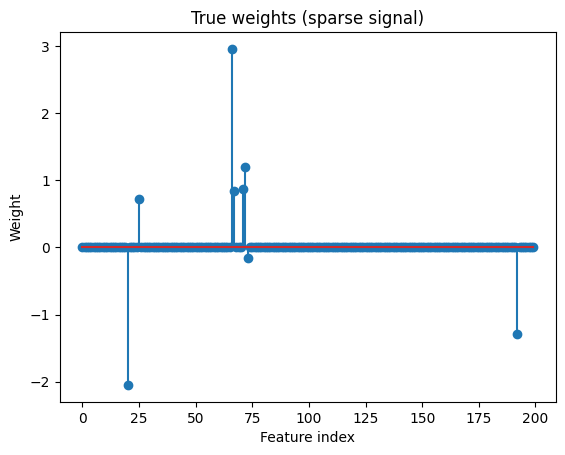

In [44]:
plt.figure()
plt.stem(w_true)
plt.title("True weights (sparse signal)")
plt.xlabel("Feature index")
plt.ylabel("Weight")
plt.show()

<Figure size 640x480 with 0 Axes>

<StemContainer object of 3 artists>

Text(0.5, 1.0, 'Least Squares weights (dense baseline)')

Text(0.5, 0, 'Feature index')

Text(0, 0.5, 'Weight')

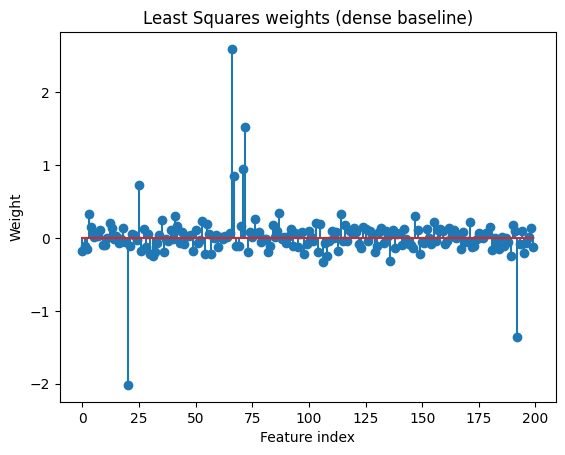

In [45]:
plt.figure()
plt.stem(w_ls)
plt.title("Least Squares weights (dense baseline)")
plt.xlabel("Feature index")
plt.ylabel("Weight")
plt.show()

<Figure size 640x480 with 0 Axes>

<StemContainer object of 3 artists>

Text(0.5, 1.0, 'Best Lasso (via CD) weights | nnz = 51 | alpha = 0.0691')

Text(0.5, 0, 'Feature index')

Text(0, 0.5, 'Weight')

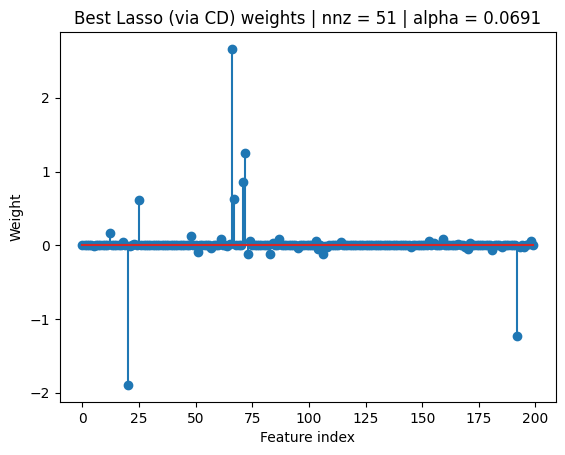

In [46]:
plt.figure()
plt.stem(best["w"])
plt.title(f"Best Lasso (via CD) weights | nnz = {best['nnz']} | alpha = {best['alpha']:.3g}")
plt.xlabel("Feature index")
plt.ylabel("Weight")
plt.show()

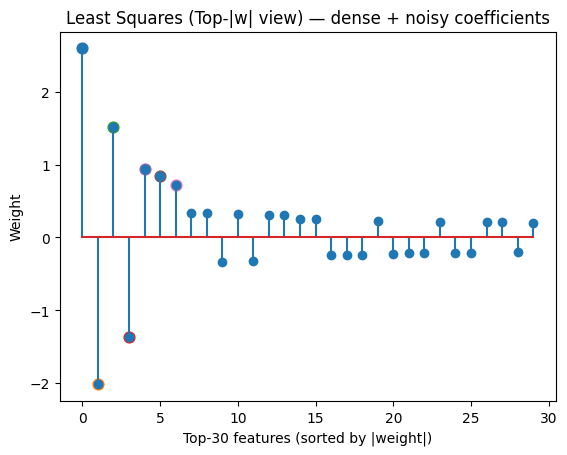

In [47]:
plot_top_weights(
    w_ls , title = "Least Squares (Top-|w| view) — dense + noisy coefficients" ,
    top = 30 , highlight_idx = set(support)
)

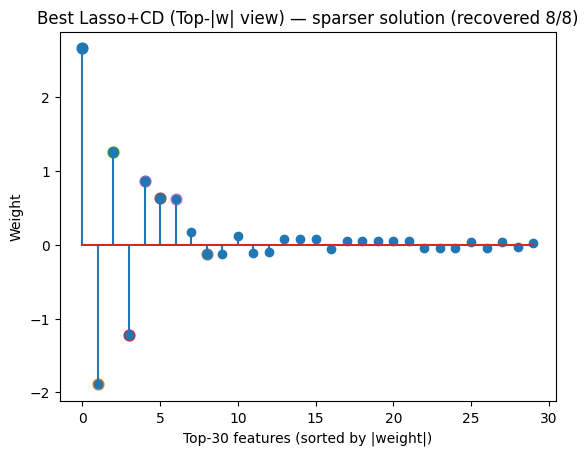

In [48]:
plot_top_weights(
    best["w"] , title = f"Best Lasso+CD (Top-|w| view) — sparser solution (recovered {recovered}/{k_true})" ,
    top = 30 , highlight_idx = set(support)
)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'MSE vs log10(alpha) (Lasso via Coordinate Descent)')

Text(0.5, 0, 'log10(alpha)')

Text(0, 0.5, 'MSE')

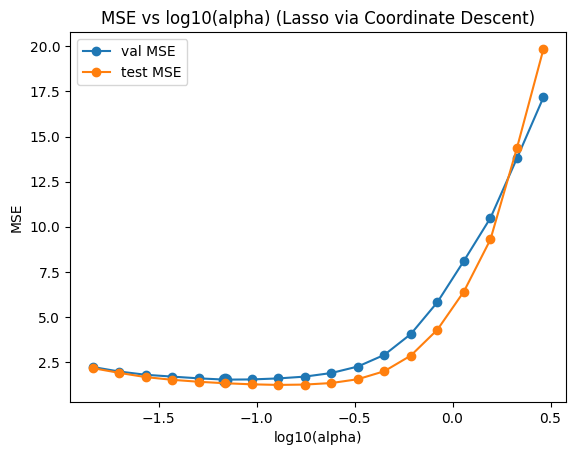

In [49]:
best_i = int(np.argmin(val_mses))
plt.figure()
plt.plot(np.log10(alphas) , val_mses , marker = "o" , label = "val MSE")
plt.plot(np.log10(alphas) , test_mses , marker = "o" , label = "test MSE")
plt.scatter(np.log10(alphas[best_i]) , val_mses[best_i] , s = 80)
plt.title("MSE vs log10(alpha) (Lasso via Coordinate Descent)")
plt.xlabel("log10(alpha)")
plt.ylabel("MSE")
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Validation MSE vs Sparsity (# non-zero weights)')

Text(0.5, 0, '# non-zero weights')

Text(0, 0.5, 'Validation MSE')

Text(56, 1.72329814095757, 'best\nnnz = 51\nval = 1.52')

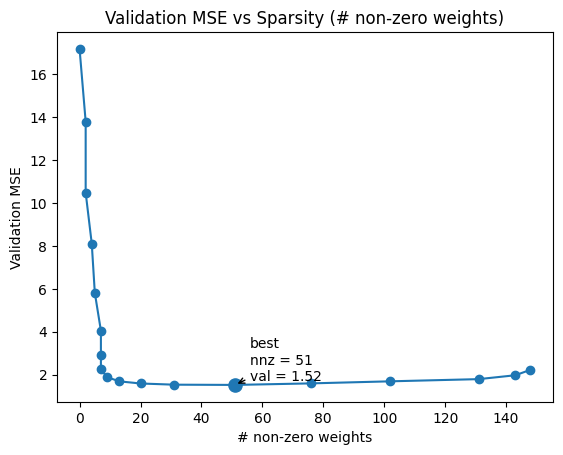

In [50]:
plt.figure()
plt.plot(nnzs , val_mses , marker = "o")
plt.scatter(best["nnz"] , best["val"] , s = 90)
plt.title("Validation MSE vs Sparsity (# non-zero weights)")
plt.xlabel("# non-zero weights")
plt.ylabel("Validation MSE")
plt.annotate(
    f"best\nnnz = {best['nnz']}\nval = {best['val']:.2f}" ,
    xy = (best["nnz"] , best["val"]) , xytext = (best["nnz"] + 5 , best["val"] + 0.2) ,
    arrowprops = dict(arrowstyle = "->")
)
plt.show()

In [51]:
print("Least Squares -> val MSE: " , round(ls_val , 3) , "| test MSE: " , round(ls_test , 3))
print("Best Lasso+CD -> val MSE: " , round(best["val"] , 3) , "| test MSE: " , round(best["test"] , 3))
print("Best Lasso+CD -> alpha: " , round(best["alpha"] , 6) ,
      "| nnz: " , best["nnz"] , f"(recovered {recovered}/{k_true} true features)")

Least Squares -> val MSE:  4.986 | test MSE:  5.192
Best Lasso+CD -> val MSE:  1.523 | test MSE:  1.322
Best Lasso+CD -> alpha:  0.069149 | nnz:  51 (recovered 8/8 true features)
